In [1]:
!gdown --id 1ixh-tv-IKMdNjpoINbILJKGRNwcfH5Tj

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ixh-tv-IKMdNjpoINbILJKGRNwcfH5Tj
From (redirected): https://drive.google.com/uc?id=1ixh-tv-IKMdNjpoINbILJKGRNwcfH5Tj&confirm=t&uuid=779068a8-1da5-4abe-bf29-9ee295ad6f96
To: /content/PageSegData.zip
100% 40.4M/40.4M [00:00<00:00, 58.6MB/s]


In [2]:
!unzip PageSegData

Archive:  PageSegData.zip
   creating: PageSegData/
   creating: PageSegData/PageImg/
  inflating: PageSegData/PageImg/1.JPG  
  inflating: PageSegData/PageImg/10.JPG  
  inflating: PageSegData/PageImg/100.JPG  
  inflating: PageSegData/PageImg/101.JPG  
  inflating: PageSegData/PageImg/102.JPG  
  inflating: PageSegData/PageImg/103.JPG  
  inflating: PageSegData/PageImg/104.JPG  
  inflating: PageSegData/PageImg/105.JPG  
  inflating: PageSegData/PageImg/106.JPG  
  inflating: PageSegData/PageImg/107.JPG  
  inflating: PageSegData/PageImg/108.JPG  
  inflating: PageSegData/PageImg/109.JPG  
  inflating: PageSegData/PageImg/11.JPG  
  inflating: PageSegData/PageImg/110.JPG  
  inflating: PageSegData/PageImg/111.JPG  
  inflating: PageSegData/PageImg/112.JPG  
  inflating: PageSegData/PageImg/113.JPG  
  inflating: PageSegData/PageImg/114.JPG  
  inflating: PageSegData/PageImg/115.JPG  
  inflating: PageSegData/PageImg/116.JPG  
  inflating: PageSegData/PageImg/117.JPG  
  inflating: Pa

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import random

image_list=os.listdir('/content/PageSegData/PageImg/')
image_list=[filename.split(".")[0]for filename in image_list]

def visualize(img,seg_img):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(seg_img,cmap='gray')
    plt.title('Segmented Image')
    plt.show()
def get_segmented_img(img,n_classes):
    """
    Loads in the segmented image and create suitable segmentation label.
    """
    seg_labels=np.zeros((512,512,1))
    img=cv2.resize(img,(512,512))
    img=img[:,:,0]
    cl_list=[0,24]


    seg_labels[:,:,0]=(img!=0).astype(int)


    return seg_labels
def preprocess_img(img):
    img=cv2.resize(img,(512,512))
    return img

def batch_generator(filelist,n_classes,batch_size):
  while True:
    X=[]
    Y=[]
    for i in range(batch_size):
      fn=random.choice(filelist)
      img=cv2.imread(f'/content/PageSegData/PageImg/{fn}.JPG',0)
      ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
      img=cv2.resize(img,(512,512))
      img=np.expand_dims(img,axis=-1)
      #img = np.stack((img,)*3, axis=-1)
      img=img/255

      seg=cv2.imread(f'/content/PageSegData/PageSeg/{fn}_mask.png',1)
      seg=get_segmented_img(seg,n_classes)

      X.append(img)
      Y.append(seg)
    yield np.array(X),np.array(Y)

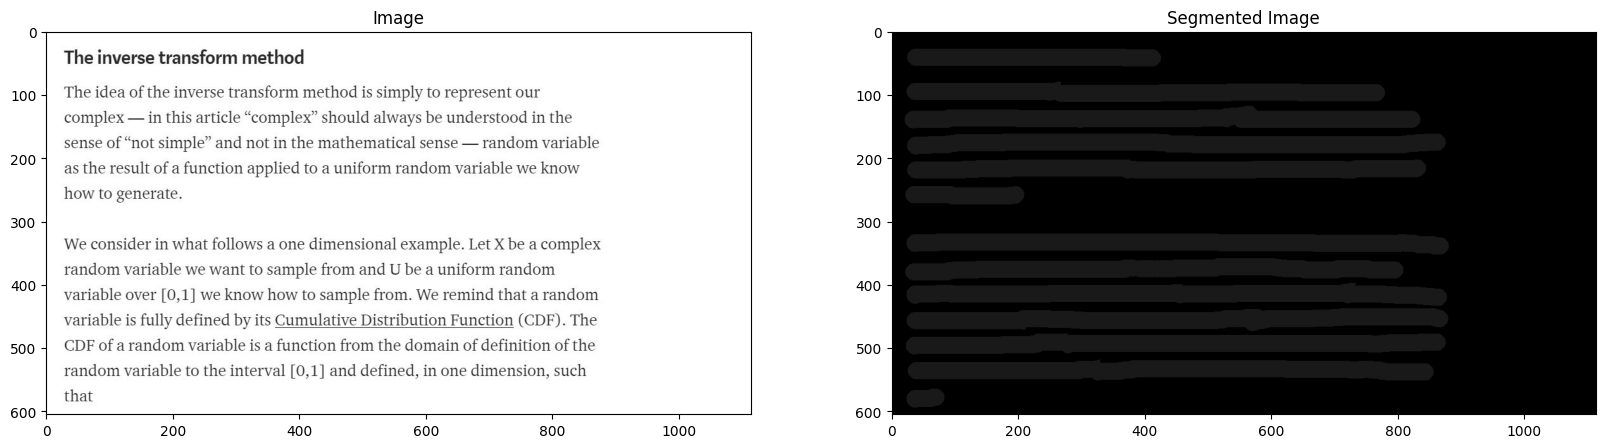

In [4]:
img=cv2.imread('/content/PageSegData/PageImg/'+image_list[0]+'.JPG',1)
seg=cv2.imread('/content/PageSegData/PageSeg/'+image_list[0]+'_mask.png',1)

visualize(img,seg)


In [5]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(learning_rate=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

model=unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,031,685 (118.38 MB)

 Trainable params: 31,031,685 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:

random.shuffle(image_list)
file_train=image_list[0:int(0.75*len(image_list))]
file_test=image_list[int(0.75*len(image_list)):]

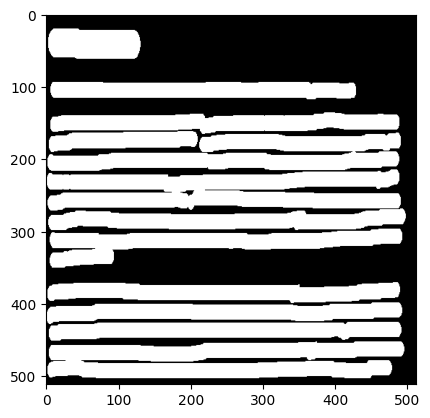

In [7]:

img,seg=next(batch_generator(file_train,2,1))
plt.imshow(np.squeeze(seg[:,:,:,0],axis=0),cmap='gray')

In [8]:
from keras.callbacks import ModelCheckpoint

# Define ModelCheckpoint callback
mc = ModelCheckpoint(
    'weights{epoch:08d}.weights.h5',  # Updated file path pattern
    save_weights_only=True,
    save_freq='epoch'  # Save at the end of each epoch
)

# Use fit method with generator
model.fit(
    batch_generator(file_train, 2, 2),
    epochs=3,
    steps_per_epoch=1000,
    validation_data=batch_generator(file_test, 2, 2),
    validation_steps=400,
    callbacks=[mc],
    shuffle=True  # Use boolean True instead of 1 for clarity
)

Epoch 1/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 751s 682ms/step - accuracy: 0.9096 - loss: 0.2260 - val_accuracy: 0.9359 - val_loss: 0.1539
Epoch 2/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 662s 662ms/step - accuracy: 0.9367 - loss: 0.1449 - val_accuracy: 0.9318 - val_loss: 0.1651
Epoch 3/3
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 683s 683ms/step - accuracy: 0.9410 - loss: 0.1337 - val_accuracy: 0.9383 - val_loss: 0.1427


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Create the model
# model = unet(pretrained_weights=False)

# Load weights
model.save_weights('/content/drive/MyDrive/human_ai_folder/unet.weights.h5')

In [13]:
import seaborn as sns
img=cv2.imread(f'/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg',0)
ret,img=cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
img=cv2.resize(img,(512,512))
img= np.expand_dims(img,axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


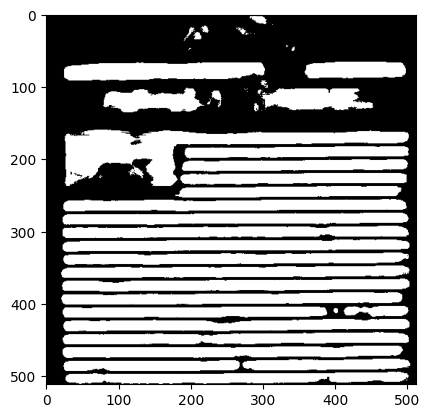

In [14]:
img=np.expand_dims(img,axis=0)
pred=model.predict(img)
pred=np.squeeze(np.squeeze(pred,axis=0),axis=-1)
plt.imshow(pred,cmap='gray')

In [15]:
plt.imsave('test_img_mask.JPG',pred)

In [17]:
coordinates=[]
import cv2
img = cv2.imread('/content/test_img_mask.JPG',0)
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread('/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg')
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a white rectangle to visualize the bounding rect
    cv2.rectangle(ori_img, (x, y), (x+w,y+h), 255, 1)
    coordinates.append([x,y,(x+w),(y+h)])

#cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

cv2.imwrite("output.png",ori_img)

True

In [18]:

import cv2

img = cv2.imread('/content/test_img_mask.JPG',0)
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
ori_img=cv2.imread('/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg')
ori_img=cv2.resize(ori_img,(512,512))
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
coordinates = []
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    coordinates.append([x, y, x+w, y+h])

# Find the minimum and maximum coordinates
min_x = min(coordinates, key=lambda x: x[0])[0]
min_y = min(coordinates, key=lambda x: x[1])[1]
max_x = max(coordinates, key=lambda x: x[2])[2]
max_y = max(coordinates, key=lambda x: x[3])[3]

# Crop the original image
cropped_img = ori_img[min_y:max_y, min_x:max_x]

cv2.imwrite("output.png", cropped_img)

True

In [19]:
import cv2

# Read the mask image in grayscale
img = cv2.imread('/content/test_img_mask.JPG', 0)
img_path='/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg'

# Apply Otsu's threshold to get a binary image
_, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Read the original image
ori_img = cv2.imread(img_path)

# Get original dimensions
ori_height, ori_width = ori_img.shape[:2]

# Resize the original image to 512x512 to find contours on the same scale
resized_img = cv2.resize(thresholded_img, (512, 512))

# Find contours
contours, _ = cv2.findContours(resized_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Initialize coordinates list
coordinates = []

# Get bounding rectangles for each contour
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    coordinates.append([x, y, x+w, y+h])

# Find the minimum and maximum coordinates on the resized image
min_x = min(coordinates, key=lambda x: x[0])[0]
min_y = min(coordinates, key=lambda x: x[1])[1]
max_x = max(coordinates, key=lambda x: x[2])[2]
max_y = max(coordinates, key=lambda x: x[3])[3]

# Calculate scale factors
x_scale = ori_width / 512.0
y_scale = ori_height / 512.0

# Scale coordinates back to original image dimensions
scaled_min_x = int(min_x * x_scale)
scaled_min_y = int(min_y * y_scale)
scaled_max_x = int(max_x * x_scale)
scaled_max_y = int(max_y * y_scale)

# Crop the original image using the scaled coordinates
cropped_img = ori_img[scaled_min_y:scaled_max_y, scaled_min_x:scaled_max_x]

# Save the cropped image
cv2.imwrite("output.png", cropped_img)



True

In [20]:
import cv2

# Read the mask image in grayscale
img = cv2.imread('/content/test_img_mask.JPG', 0)

# Apply Otsu's threshold to get a binary image
_, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Read the original image
ori_img = cv2.imread(img_path)

# Get original dimensions
ori_height, ori_width = ori_img.shape[:2]

# Resize the original image to 512x512 to find contours on the same scale
resized_img = cv2.resize(thresholded_img, (512, 512))

# Find contours
contours, _ = cv2.findContours(resized_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Initialize coordinates list
coordinates = []

# Get bounding rectangles for each contour
for c in contours:
  x, y, w, h = cv2.boundingRect(c)
  coordinates.append([x, y, x+w, y+h])

# Find the minimum and maximum coordinates on the resized image
min_x = min(coordinates, key=lambda x: x[0])[0]
min_y = min(coordinates, key=lambda x: x[1])[1]
max_x = max(coordinates, key=lambda x: x[2])[2]
max_y = max(coordinates, key=lambda x: x[3])[3]

# Calculate scale factors
x_scale = ori_width / 512.0
y_scale = ori_height / 512.0

# Scale coordinates back to original image dimensions
scaled_min_x = int(min_x * x_scale)
scaled_min_y = int(min_y * y_scale)
scaled_max_x = int(max_x * x_scale)
scaled_max_y = int(max_y * y_scale)

# Define padding in pixels
padding = 10

# Add padding, ensuring coordinates stay within image bounds
scaled_min_x = max(0, scaled_min_x - padding)
scaled_min_y = max(0, scaled_min_y - padding)
scaled_max_x = min(ori_width, scaled_max_x + padding)
scaled_max_y = min(ori_height, scaled_max_y + padding)

# Crop the original image using the padded coordinates
cropped_img = ori_img[scaled_min_y:scaled_max_y, scaled_min_x:scaled_max_x]

# Save the cropped image
cv2.imwrite("output.png", cropped_img)


True

In [22]:
import cv2
import numpy as np

def crop_text_region(mask_path, original_image_path, output_path):
    # Read the mask image in grayscale
    mask = cv2.imread(mask_path, 0)

    # Read the original image
    original_img = cv2.imread(original_image_path)

    # Get original dimensions
    ori_height, ori_width = original_img.shape[:2]

    # Resize the mask to match the original image dimensions
    resized_mask = cv2.resize(mask, (ori_width, ori_height))

    # Apply Otsu's threshold to get a binary image
    _, binary_mask = cv2.threshold(resized_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to remove noise and connect nearby text
    kernel = np.ones((5,5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)

    # Find contours in the cleaned mask
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area to remove small noise
    min_contour_area = 100  # Adjust this value as needed
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    if not valid_contours:
        print("No valid text regions found.")
        return None

    # Find the bounding rectangle that encompasses all valid contours
    x_min, y_min = ori_width, ori_height
    x_max, y_max = 0, 0

    for contour in valid_contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    #add padding
    padding = 10
    x_min = max(0, x_min - padding)
    y_min = max(0, y_min - padding)
    x_max = min(ori_width, x_max + padding)
    y_max = min(ori_height, y_max + padding)

    # Crop the original image
    cropped_img = original_img[y_min:y_max, x_min:x_max]

    # Save the cropped image
    cv2.imwrite(output_path, cropped_img)

    return output_path

# Usage
mask_path = '/content/test_img_mask.JPG'
original_image_path = '/content/drive/MyDrive/human_ai_folder/processed_images/Buendia-page_1.jpg'
output_path = '/content/output1.png'


result = crop_text_region(mask_path, original_image_path, output_path)
if result:
    print(f"Cropped image saved to: {result}")
else:
    print("Failed to crop the image.")




Cropped image saved to: /content/output1.png


In [23]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

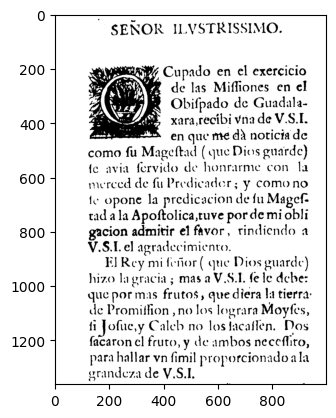

In [24]:
img = cv2.imread('/content/drive/MyDrive/human_ai_folder/processed_images/Ezcaray-page_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

if w > 1000:

    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)

    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img);


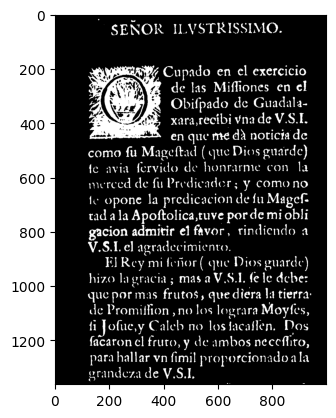

In [25]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img);

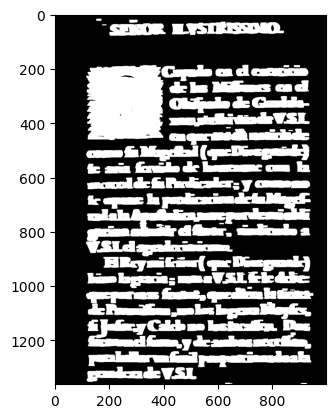

In [26]:

#dilation
kernel = np.ones((4,16), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

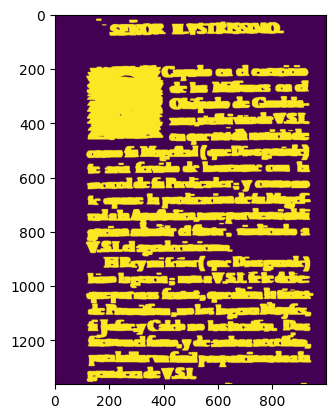

In [27]:

dark_grey_value = 40
light_grey_value = 0
mask_grey = np.where(dilated > 240, dark_grey_value, light_grey_value).astype(np.uint8)
cv2.imwrite("20_mask.png",mask_grey)
plt.imshow(mask_grey);